<a href="https://colab.research.google.com/github/saskiad/Computational-Neuroscience-Webinar/blob/main/Visual_Coding_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro the the Allen Brain Observatory Visual Coding Ophys Dataset.
This notebook demonstrates how to access and visualize data.

In [ ]:
# @title Run to initialize Allen Brain Observatory on Colab {display-mode: "form" }
# run only once per runtime/session, and only if running in colab
# the runtime will need to restart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1
!pip install numpy==1.26.4.

Standard Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Allen Brain Observatory set up
This instantiates the tools in the Allen SDK that allow us to access the Brain Observatory data.

The main entry point is the `BrainObservatoryCache` class. This class is responsible for accessing any data or metadata.

We begin by importing the `BrainObservatoryCache` class and instantiating it, pointing it to our manifest file.

`manifest_file` is a path to the where the manifest file is located. This needs to reflect where you are storing and accessing the data. Here, we are pointing it to the data on the S3 bucket.

In [ ]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = '/data/allen-brain-observatory/visual-coding-2p/manifest.json'
boc = BrainObservatoryCache(manifest_file=manifest_file)

The Brain Observatory Cache enables us to see the dimensions of the dataset.

Let's take a look at the available depths, cre lines, areas, and stimuli available in the Brain Observatory datsset.



In [ ]:
# list of all targeted areas
boc.get_all_targeted_structures()

['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']

In [ ]:
# list of all cre driver lines
boc.get_all_cre_lines()

['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']

In [ ]:
# list of all imaging depths
boc.get_all_imaging_depths()

[175,
 185,
 195,
 200,
 205,
 225,
 250,
 265,
 275,
 276,
 285,
 300,
 320,
 325,
 335,
 350,
 365,
 375,
 390,
 400,
 550,
 570,
 625]

In [ ]:
# list of all stimuli
boc.get_all_stimuli()

['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']

# Experiment containers
The `experiment container` describes a set of 3 `sessions` performed for the same field of view (ie. same targeted area and imaging depth in the same mouse that targets the same set of neurons). Each experiment container has a unique ID number.

Choose a visual area and Cre line from the lists above

In [ ]:
visual_area = 'VISal'
cre_line ='Cux2-CreERT2'

Get the list of all the experiment containers for that area and Cre line combination.

In [ ]:
exps = boc.get_experiment_containers(targeted_structures=[visual_area], cre_lines=[cre_line])

In [ ]:
pd.DataFrame(exps)

,id,imaging_depth,targeted_structure,cre_line,reporter_line,donor_name,specimen_name,tags,failed
0,511854338,275,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),233215,Cux2-CreERT2;Camk2a-tTA;Ai93-233215,[],False
1,698102441,276,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),339323,Cux2-CreERT2;Camk2a-tTA;Ai93-339323,[],False
2,511510715,175,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),222426,Cux2-CreERT2;Camk2a-tTA;Ai93-222426,[],False
3,638056632,275,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),339323,Cux2-CreERT2;Camk2a-tTA;Ai93-339323,[],False
4,511510867,275,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),228379,Cux2-CreERT2;Camk2a-tTA;Ai93-228379,[],False
5,511510998,175,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),229105,Cux2-CreERT2;Camk2a-tTA;Ai93-229105,[Epileptiform Events],False
6,511510664,175,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),222420,Cux2-CreERT2;Camk2a-tTA;Ai93-222420,[],False
7,511510797,175,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),225036,Cux2-CreERT2;Camk2a-tTA;Ai93-225036,[],False
8,511510695,175,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),222425,Cux2-CreERT2;Camk2a-tTA;Ai93-222425,[],False
9,511511052,275,VISal,Cux2-CreERT2,Ai93(TITL-GCaMP6f),228378,Cux2-CreERT2;Camk2a-tTA;Ai93-228378,[],False


Let's look at one experiment container, imaged from Cux2, in VISp, from imaging depth 175 um.

In [ ]:
experiment_container_id = 511510736

Let's get all of the sessions for this container.

In [ ]:
pd.DataFrame(boc.get_ophys_experiments(experiment_container_ids=[experiment_container_id]))

,id,imaging_depth,targeted_structure,cre_line,reporter_line,acquisition_age_days,experiment_container_id,session_type,donor_name,specimen_name,fail_eye_tracking
0,501704220,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),104,511510736,three_session_A,222426,Cux2-CreERT2;Camk2a-tTA;Ai93-222426,True
1,501559087,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),103,511510736,three_session_B,222426,Cux2-CreERT2;Camk2a-tTA;Ai93-222426,True
2,501474098,175,VISp,Cux2-CreERT2,Ai93(TITL-GCaMP6f),102,511510736,three_session_C,222426,Cux2-CreERT2;Camk2a-tTA;Ai93-222426,True


Let's find the session from this container that used the `natural_scenes` stimulus.

In [ ]:
boc.get_ophys_experiments(experiment_container_ids=[experiment_container_id], stimuli=['natural_scenes'])


[{'id': 501559087,
  'imaging_depth': 175,
  'targeted_structure': 'VISp',
  'cre_line': 'Cux2-CreERT2',
  'reporter_line': 'Ai93(TITL-GCaMP6f)',
  'acquisition_age_days': 103,
  'experiment_container_id': 511510736,
  'session_type': 'three_session_B',
  'donor_name': '222426',
  'specimen_name': 'Cux2-CreERT2;Camk2a-tTA;Ai93-222426',
  'fail_eye_tracking': True}]

Each session has a unique ID, and we can use that ID to access the data for this session.

In [ ]:
session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_container_id],
                                       stimuli=['natural_scenes'])[0]['id']
print(session_id)

501559087


# Ophys Experiment data
This gives us access to everything in the NWB file for a single imaging session

In [ ]:
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

We can use this `data_set` object to access all the pieces of data for the session. Let's take a look.

# Maximum projection
This is the projection of the full motion corrected movie. It shows all of the neurons imaged during the session.

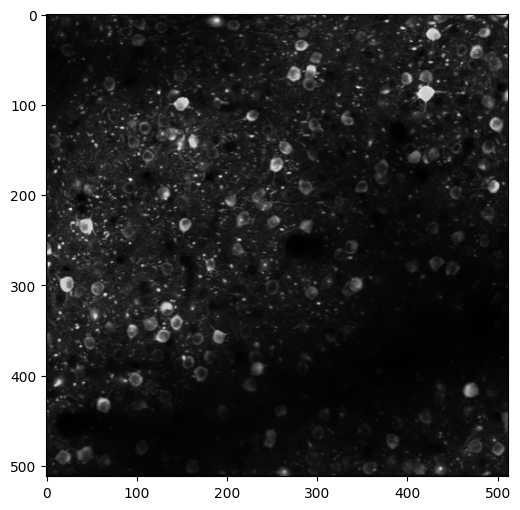

In [ ]:
max_projection = data_set.get_max_projection()

fig = plt.figure(figsize=(6,6))
plt.imshow(max_projection, cmap='gray')

# ROI Masks
These are all of the segmented masks for cell bodies in this experiment.

In [ ]:
rois = data_set.get_roi_mask_array()

In [ ]:
print(rois.shape)
print("Number of cells:", rois.shape[0])

(174, 512, 512)
Number of cells: 174


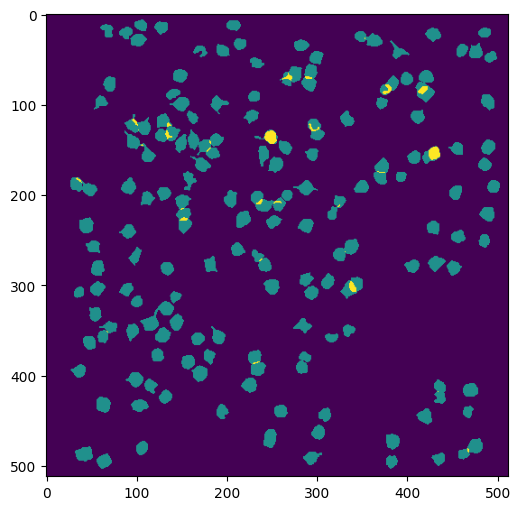

In [ ]:
plt.figure(figsize=(6,6))
plt.imshow(rois.sum(axis=0))

# DF/F Traces
There are a number of accessible traces in the NWB file, including raw fluorescence, neuropil corrected traces, demixed traces, and DF/F traces. There are also extracted events available.
In this tutorial we will us DF/F to examine neural activity.

In [ ]:
ts, dff = data_set.get_dff_traces()

In [ ]:
dff.shape

(174, 113888)

Let's plot the activity of the first 50 neurons from this session.

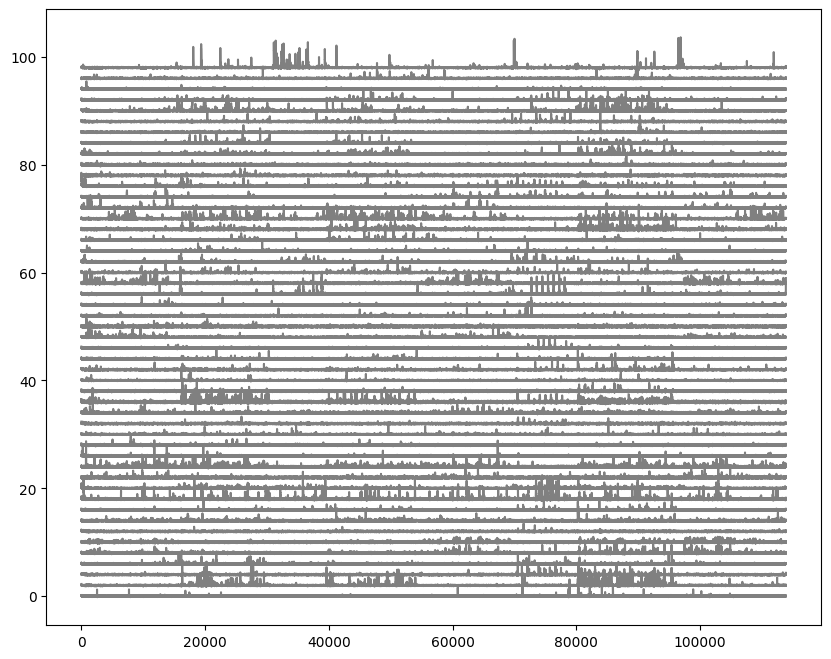

In [ ]:
fig = plt.figure(figsize=(10,8))
for i in range(50):
    plt.plot(dff[i,:]+(i*2), color='gray')

# Stimulus epochs
Several stimuli are shown during each imaging session, interleaved with each other. The stimulus epoch table provides information of these interleaved stimulus epochs

In [ ]:
stim_epoch = data_set.get_stimulus_epoch_table()
stim_epoch

,stimulus,start,end
0,static_gratings,747,15196
1,natural_scenes,16100,30551
2,spontaneous,30701,39581
3,natural_scenes,39582,54050
4,static_gratings,54953,69403
5,natural_movie_one,70307,79338
6,natural_scenes,80241,96126
7,static_gratings,97406,113662


Let's add the stimulus epoch information to the plot of neural activity.

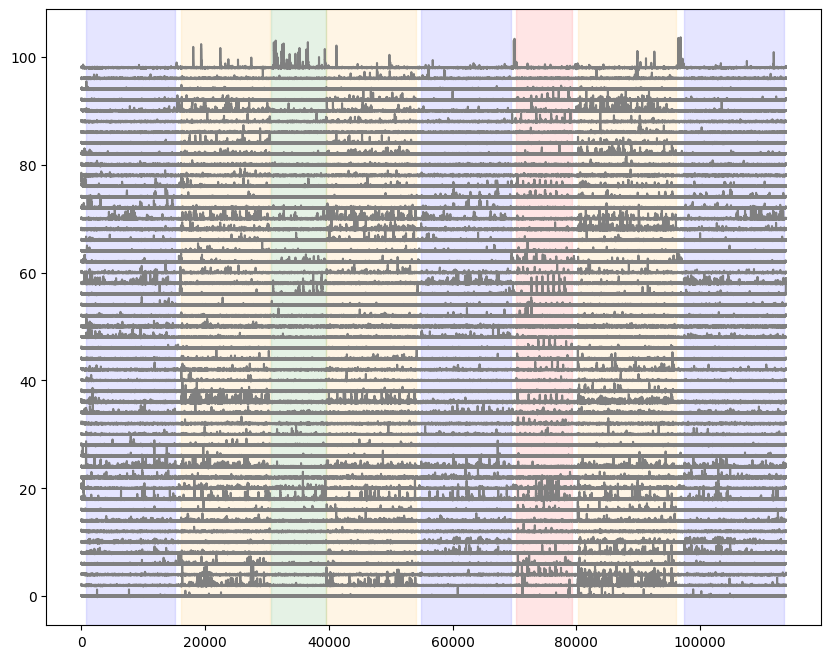

In [ ]:
#plot activity of first 50 neurons
fig = plt.figure(figsize=(10,8))
for i in range(50):
    plt.plot(dff[i,:]+(i*2), color='gray')

#for each stimulus, shade the plot when the stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)


# Running speed
The running speed of the animal on the rotating disk during the entire session.

Text(0, 0.5, 'Running speed (cm/s)')

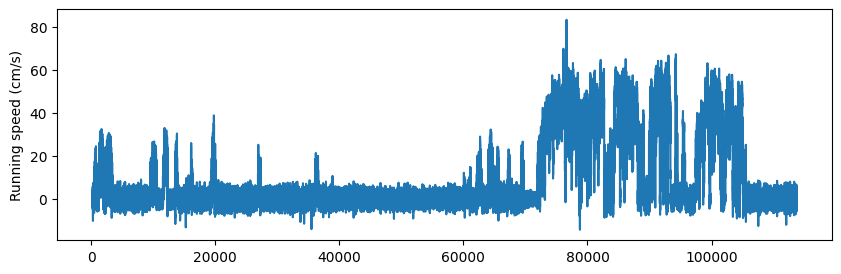

In [ ]:
dxcm, tsd = data_set.get_running_speed()

fig = plt.figure(figsize=(10,3))
plt.plot(dxcm)
plt.ylabel("Running speed (cm/s)")

Let's add the running speed to our plot of neural activity and stimulus epochs.

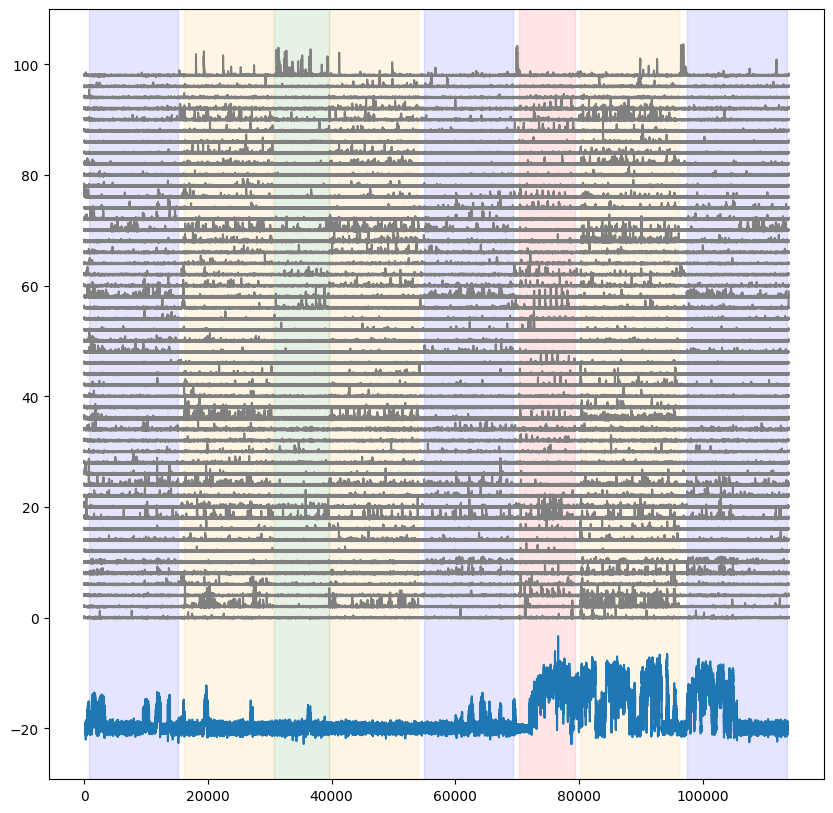

In [ ]:
#plot activity of first 50 neurons
fig = plt.figure(figsize=(10,10))
for i in range(50):
    plt.plot(dff[i,:]+(i*2), color='gray')

#plot the running speed (scaled and offset to fit)
plt.plot((0.2*dxcm)-20)

#for each stimulus, shade the plot when the stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)


Let's look at a few individual neurons.

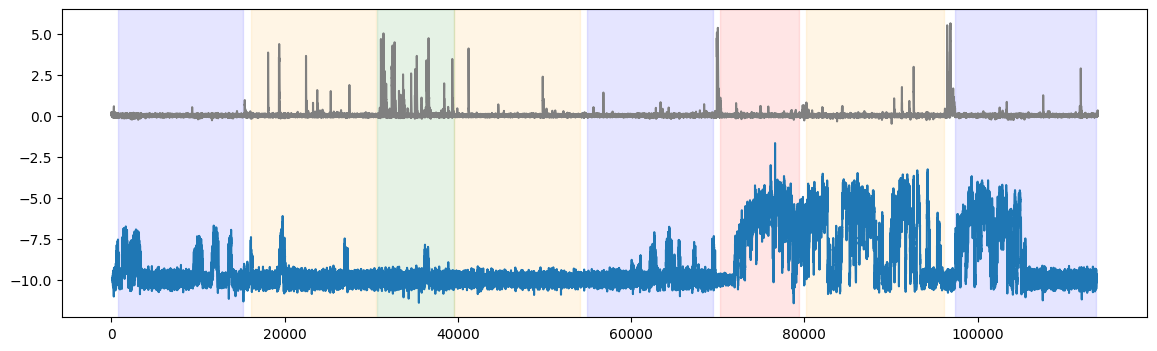

In [ ]:
fig = plt.figure(figsize=(14,4))

plt.plot(dff[49,:], color='gray')
plt.plot((0.1*dxcm)-10)

#for each stimulus, shade the plot when the stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)


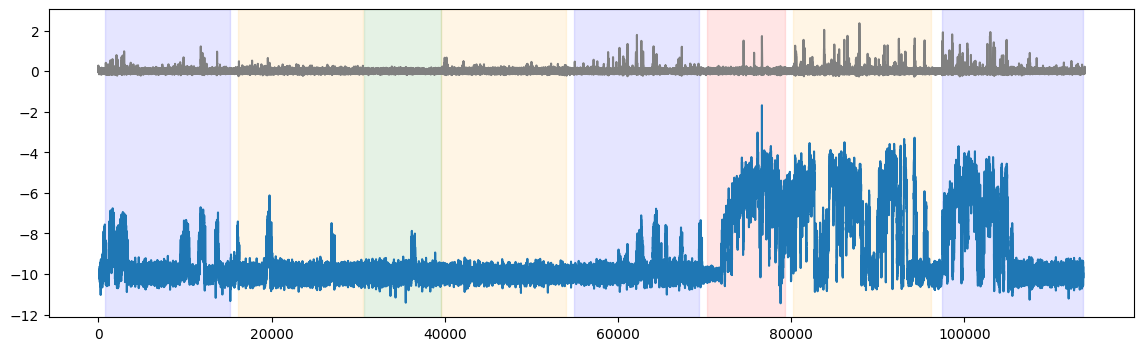

In [ ]:
fig = plt.figure(figsize=(14,4))

plt.plot(dff[4,:], color='gray')
plt.plot((0.1*dxcm)-10)

#for each stimulus, shade the plot when the stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)

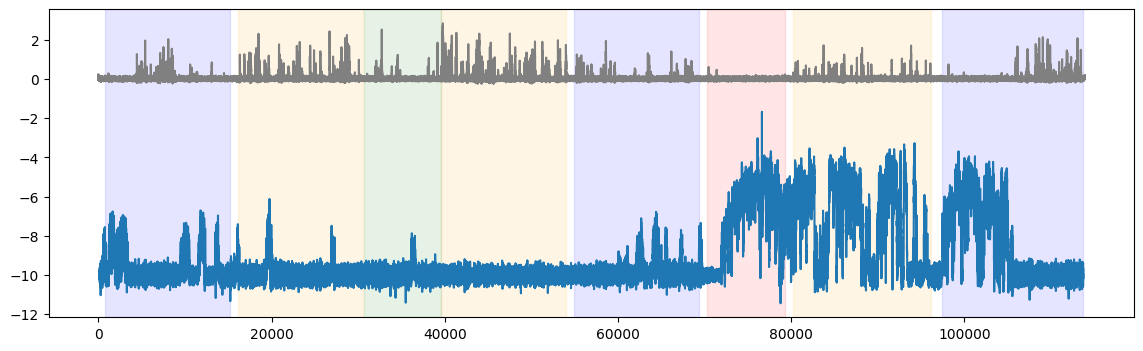

In [ ]:
fig = plt.figure(figsize=(14,4))

plt.plot(dff[35,:], color='gray')
plt.plot((0.1*dxcm)-10)

#for each stimulus, shade the plot when the stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)

# Stimulus Table
For each stimulus there is a stimulus table with information about the condition and timing of each trial.

In [ ]:
natural_scene_table = data_set.get_stimulus_table('natural_scenes')
natural_scene_table.head(n=10)

,frame,start,end
0,81,16100,16107
1,33,16108,16115
2,76,16115,16122
3,13,16123,16130
4,56,16130,16137
5,30,16138,16145
6,44,16145,16152
7,93,16153,16160
8,65,16160,16167
9,60,16168,16175


# Stimulus Template
The images and movies presented during the session area also included in the NWB file as the stimulus template. Stimuli that are generated programmatically (eg. drifting and static gratings) do not have a stimulus template. There are tools in the SDK to recreate these stimuli.

In [ ]:
natural_scene_template = data_set.get_stimulus_template('natural_scenes')

In [ ]:
natural_scene_template.shape

(118, 918, 1174)

Let's look at the scene presented in the first trial.

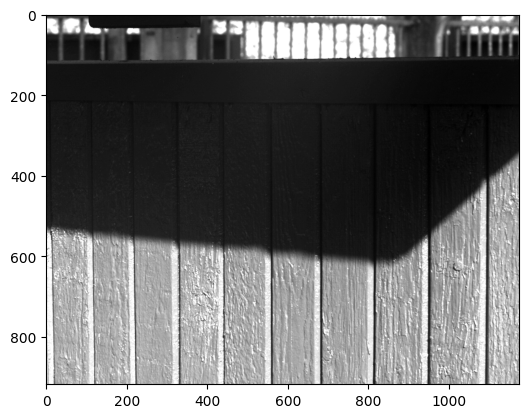

In [ ]:
scene_number = natural_scene_table.frame.loc[0]
plt.imshow(natural_scene_template[scene_number,:,:], cmap='gray')

We can add the trials of this image to the plot of neural activity too:

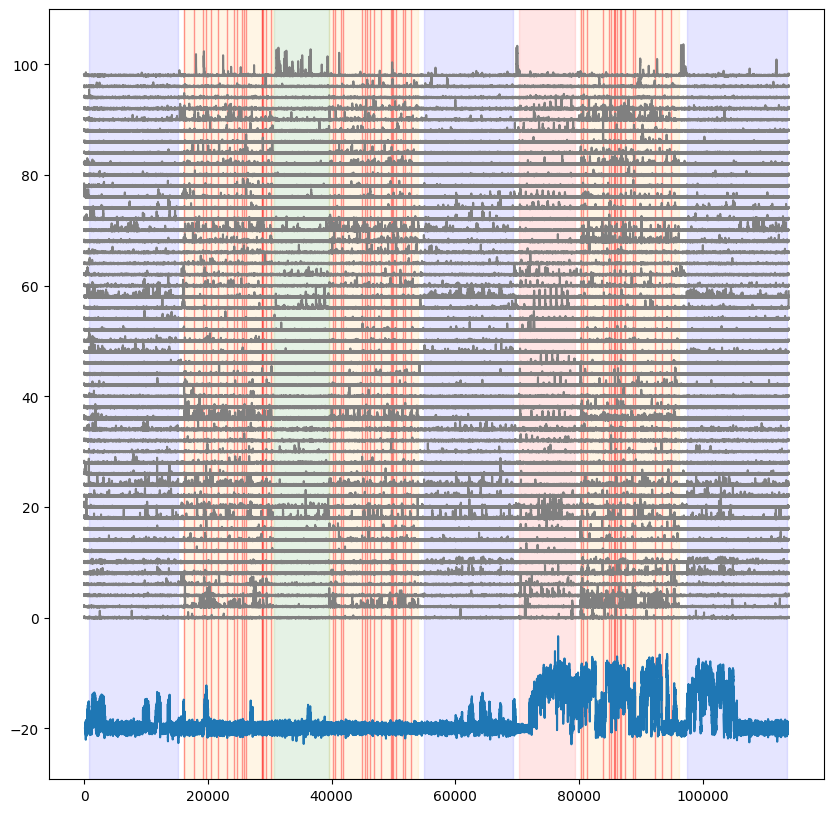

In [ ]:
#plot activity of first 50 neurons
fig = plt.figure(figsize=(10,10))
for i in range(50):
    plt.plot(dff[i,:]+(i*2), color='gray')

#plot the running speed (scaled and offset to fit)
plt.plot((0.2*dxcm)-20)

#for each stimulus, shade the plot when the stimulus is presented
colors = ['blue','orange','green','red']
for c,stim_name in enumerate(stim_epoch.stimulus.unique()):
    stim = stim_epoch[stim_epoch.stimulus==stim_name]
    for j in range(len(stim)):
        plt.axvspan(xmin=stim.start.iloc[j], xmax=stim.end.iloc[j], color=colors[c], alpha=0.1)

#shade traces with the time of each presentation of the above scene
stim_subset = natural_scene_table[natural_scene_table.frame==scene_number]
for j in range(len(stim_subset)):
    plt.axvspan(xmin=stim_subset.start.iloc[j], xmax=stim_subset.end.iloc[j], color='red', alpha=0.4)

We can zoom in on these trials. We'll look at one neuron's responses to all the trials of one image.

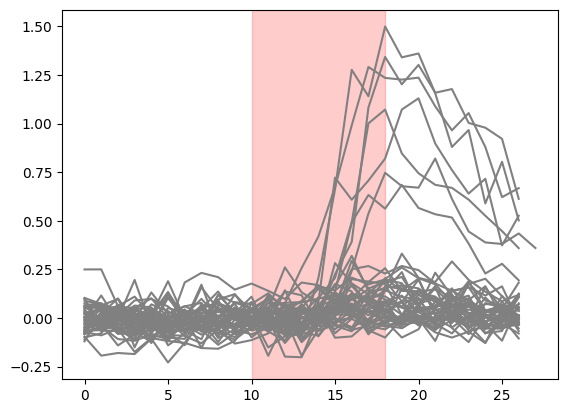

In [ ]:
cell_index=19
scene_number=22

stim_subset = natural_scene_table[natural_scene_table.frame==scene_number]

for i in range(len(stim_subset)):
    plt.plot(dff[cell_index,stim_subset.start.iloc[i]-10:stim_subset.end.iloc[i]+10], color='gray')
plt.axvspan(10,18, color='red',alpha=0.2)
